# Plot population minor allele frequencies (MAFs) for genes

Let's compare the MAF for a few populations over the [APOE gene](https://www.ncbi.nlm.nih.gov/variation/view/?cfg=NCID_1_20854257_130.14.22.10_9146_1558129725_3670287406) region.
The region is located on chromosome 19 (NC_000019.10): 44,905,384 - 44,909,760

## Requirements
There are a few things we need to do before starting:

NB: This workbook has been tested with Python 3.6 and Python 3.7.

In [1]:
%pip install -q requests matplotlib > /dev/null

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

In [3]:
from requests import get

import matplotlib.pyplot as plt
from collections import defaultdict
import sys

In [4]:
plt.rcParams['figure.figsize'] = [16, 8]  # Make plot bigger

## Download data
Here is a genomic region we are going to plot:

In [5]:
seq_id = 'NC_000019.10'
start = 44905384
stop = 44909760

In [6]:
resp = get(f'https://api.ncbi.nlm.nih.gov/variation/v0/interval/{seq_id}:{start}:{stop - start}/overlapping_frequency_records')
print(resp.status_code)

206


**Status code**: `206` means that not all the requested variants fit into a single reply.
So we need to parse the data, get the latest position and continue requesting data until we get a reply with status code 200.

In [7]:
def download(seq_id: str, start: int, stop: int):
    """
    Download all frequencies in a specified region
    """
    data = {}
    while True:
        length = max(1, stop - start + 1)
        resp = get(f'https://api.ncbi.nlm.nih.gov/variation/v0/interval/{seq_id}:{start}:{length}/overlapping_frequency_records')
        if resp.status_code // 100 != 2:
            raise Exception("Unable to download data", resp.status_code, resp.content)
        result = resp.json()["results"]
        data.update(result)
        if resp.status_code == 200:
            return data  # We are done

        for k,v in result.items():
            l, s = k.split('@')
            start = max(start, int(s))

In [8]:
data = download(seq_id, start, stop)

In [9]:
print("Number of variations: ", len(data))

Number of variations:  1472


Now, for each record, we need to calculate MAF per population

In [10]:
def maf(record):
    """
    Calculate minor allele frequencies (MAFs) for all populations within the given record
    """
    maf = {}  # Population to MAF
    for project, counts in record['counts'].items():
        for population, ac in counts['allele_counts'].items():
            counts = [allele_count for allele, allele_count in ac.items()]
            counts.sort(reverse=True)
            if len(counts) <= 1:
                maf[population] = 0
                continue
            total = sum(counts)
            if total > 0: 
                maf[population] = counts[1] / total
            else:
                maf[population] = 0
    return maf

In [11]:
def translate(data):
    """
    Translate overlapped region endpoint result to data ready to plot.
    """
    position = []
    freq = defaultdict(list)
    for k, v in data.items():
        l, s = k.split('@')
        start = int(s)
        position.append(start)
        mafs = maf(v)
        for p, ma in mafs.items():
            freq[p].append(ma)
    return position, freq

In [12]:
x, pop = translate(data)

## Metadata
If we look into this data we will see that all populations were reported using their biosample ids. That is not the best way to use in a visualization.
So, we are going to translate it to human readable form: here is where the metadata service is helpful.

In [13]:
def build_pop_map():
    """
    Download metadata and parse it.
    """
    meta_r = get('https://api.ncbi.nlm.nih.gov/variation/v0/metadata/frequency')
    if meta_r.status_code != 200:
        raise Exception("Can't download metadata")
    result = {}
    def _read(pops):
        for pop in pops:
            result[pop["biosample_id"]] = pop["name"]
            if "subs" in pop:
                _read(pop["subs"])
    _read(meta_r.json()[0]["populations"])
    return result

In [14]:
meta = build_pop_map()  # Now meta is the map of biosample_id to population name

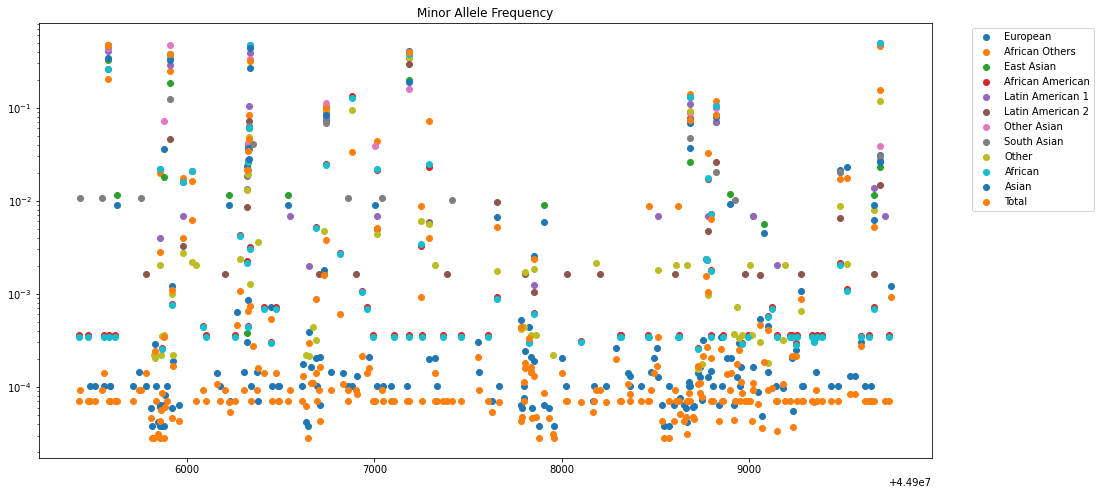

In [15]:
from matplotlib import cycler
def show1():
    for p, data in pop.items():
        # Plot only non-zero MAF
        filtered_x = [xx for i,xx in enumerate(x) if data[i] > 0]
        filtered_data = [dd for i,dd in enumerate(data) if data[i] > 0]
        plt.scatter(filtered_x, filtered_data, label=meta[p])

    plt.title('Minor Allele Frequency')
    plt.legend(loc=2, bbox_to_anchor=(1.04,1))
    plt.yscale('log')
    num_colors = len(meta)
    colormap = plt.get_cmap('gist_rainbow')
    plt.rc('axes', prop_cycle=cycler(color=[colormap(1.*i/num_colors) for i in range(num_colors)]))
    plt.show()
show1()

# Comparing population frequencies
Let's build a scatter plot for allele frequencies for two populations.

In [16]:
def cross_frequency(data, pop_id_x, pop_id_y):
    
    res_x = defaultdict(list)
    res_y = defaultdict(list)
    records_missing_pop_data = 0
    total_records = 0
    for _, record in data.items():
        total_records += 1
        for _, counts in record['counts'].items():
            
            px = counts['allele_counts'][pop_id_x]
            py = counts['allele_counts'][pop_id_y]
            
            def _pop_freq(p):
                r = {}
                total = sum([allele_count for allele, allele_count in p.items()])
                if total == 0: # This population had no one with any measurements
                    return None
                for allele, allele_count in p.items():
                    r[allele] = allele_count / total
                return r
            pfx = _pop_freq(px)
            pfy = _pop_freq(py)
            if pfx is None or pfy is None:
              records_missing_pop_data += 1
              continue
            for a, fx in pfx.items():
                if a in pfy:
                    res_x[a].append(fx)
                    res_y[a].append(pfy[a])
    print(f"Skipped {records_missing_pop_data} of {total_records} records because they had no measurements for one of the populations",
         file=sys.stderr)
    return res_x, res_y

In [17]:
def show_cross_frequency(seq_id, start, stop, pop_x, pop_y):
    data = download(seq_id, start, stop)
    cf_x, cf_y = cross_frequency(data, pop_x, pop_y)
    for allele, allele_freq_x in cf_x.items():
        allele_freq_y = cf_y[allele]
        
        plt.scatter(allele_freq_x, allele_freq_y, label=allele)
        plt.xlabel(meta[pop_x])
        plt.ylabel(meta[pop_y])
    plt.title(f'Cross Allele frequency {seq_id}, {start}, {stop}')
    plt.show()

Skipped 9 of 1472 records because they had no measurements for one of the populations


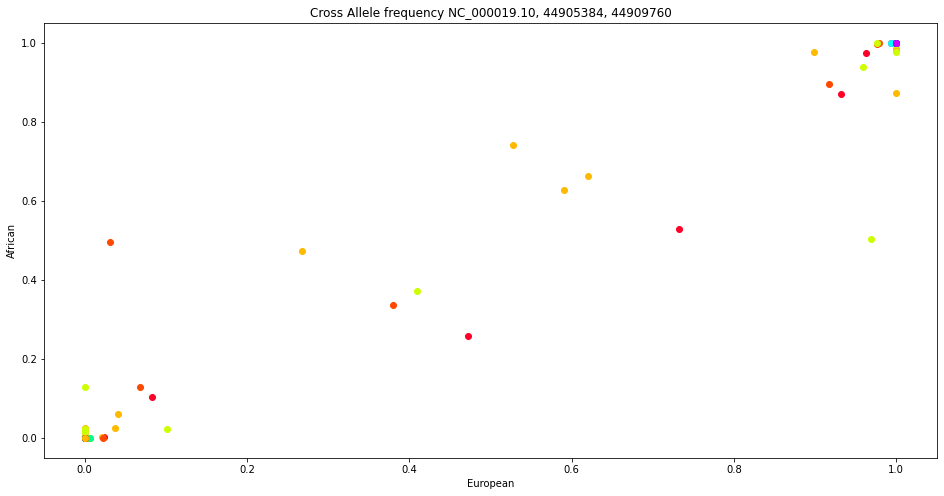

In [18]:
show_cross_frequency('NC_000019.10', 44905384, 44909760, 'SAMN10492695', 'SAMN10492703')

Skipped 33 of 4582 records because they had no measurements for one of the populations


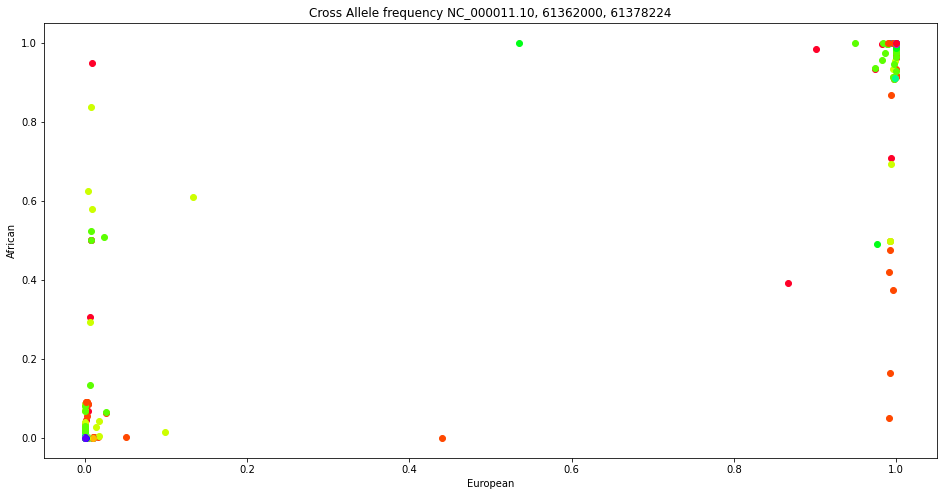

In [19]:
show_cross_frequency('NC_000011.10',61362000, 61378224, 'SAMN10492695', 'SAMN10492703')

In [24]:
def show_genesum_frequency(data):

    plt.rcParams["figure.figsize"] = [15, 7]
    plt.rcParams["figure.autolayout"] = True

    for p, data in pop.items():
        # Plot only non-zero MAF
        filtered_x = [xx for i,xx in enumerate(x) if data[i] > 0]
        filtered_data = [dd for i,dd in enumerate(data) if data[i] > 0]
        plt.scatter(filtered_x, filtered_data, label=meta[p])
        
    population = [2014, 2015, 2016, 2017, 2018, 2019]
    issues_addressed = [10, 14, 0, 10, 15, 15]
    issues_pending = [5, 10, 50, 2, 0, 10]

    b1 = plt.barh(year, issues_addressed, color="red")

    b2 = plt.barh(year, issues_pending, left=issues_addressed, color="yellow")
    
    plt.title(f'Gene Allele Frequency Summary')

    plt.legend([b1, b2], ["Completed", "Pending"], title="Issues", loc="upper right")

    plt.show()
   

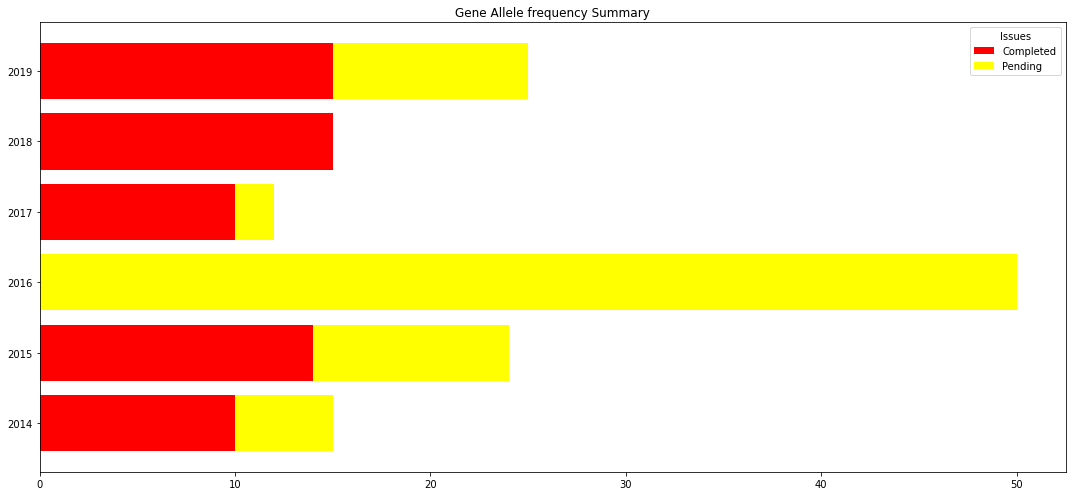

In [25]:
show_genesum_frequency()